
# Monarch 🦋

_A python-native distributed programming framework_


In [ ]:
%load_ext autoreload
%autoreload 2
import monarch
import monarch.job
import assets, demo

Training models at large scale has unique systems challenges.

* Pre-training requires careful coordination of **tens of thousands of GPUs**.
* The **strategy** to efficiently use the GPUs **changes with model size and datacenter size**.
* And a **failure** of single component can **deadlock** an entire job.

# Post-training complexity

Post-training combines the complexity of pre-training with complex **asynchrony** of many other components:
* A **learner** to update the model
* **Generators** to produce new trajectories to use as input to training.
* **Environments** which let the generators use external tools like webbrowsers or coding environments
* **Parameter Servers** to quickly transfer weights to keep things on policy.

![][image1]

[image1]: <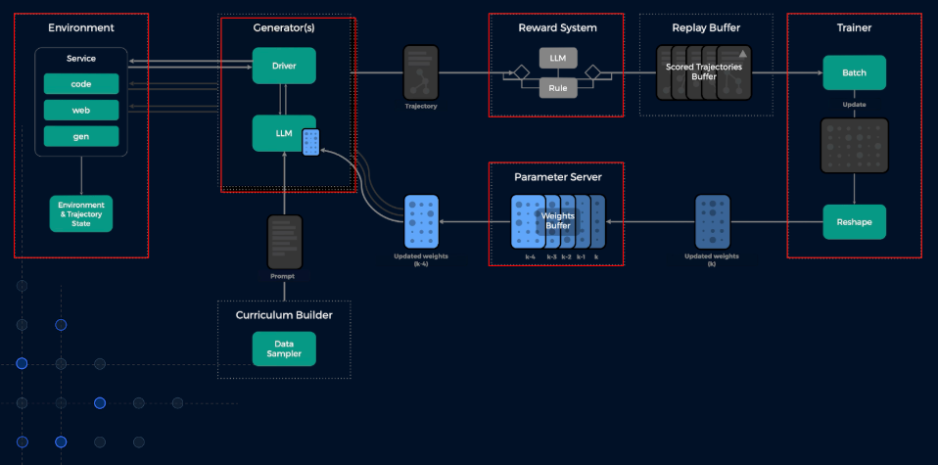>

The competitive advantage in the space comes from being able to prototype these setups quickly.

# Introducing Monarch

Monarch is python API for building distributed machine learning systems imperatively.


Its _fundamental design principle_ is that **everything is a python API**


This includes:
* acquiring machines
* launching processes on them
* and quickly communicating between them using actors and RDMA

With monarch, _a single program defines the entire ML system_,
maximizing researcher productivity by making new ideas easy to try.

It is like programming a cluster as if it were a single machine. 

# A Python API for Constructing ML Systems

In [ ]:
job = monarch.job.LocalJob(hosts=('trainers',)).state()

async def dataloader(nsamples: int):
    return [demo.TrajectorySlice.fake() for _ in range(nsamples)]

# spawn trainer actors
trainers = (job.trainers # HostMesh
               .spawn_procs(per_host={'gpu': 8}) # ProcMesh
               .spawn("learner", demo.Learner, dataloader)) # ActorMesh

Monarch uses an imperative API to launch actors onto hosts.

* Hosts are handles to machines usable by monarch. They can be the local machine, or acquired through a job management API like SLURM.
* Procs are processes launched onto hosts that will contain actors. They map 1-1 to true linux processes and provide isolation.
* Actors are spawned onto procs. Actors are the way different parts of monarch communicate.

# Actors for messaging
You can send message actors by calling their endpoint. Here we ask the trainer actors to take a step in the training process:

In [ ]:
loss_fut: monarch.actor.Future[float] = trainers.step.call()
# wait for the actors to finish and respond
print(loss_fut.get())

Actors are described as python classes:


In [ ]:
import inspect
print(inspect.getsource(demo.Learner))

# Meshes of Actors/Processes/Hosts for Scale

Hosts, processes, actors, and the values they produce are all organized into **meshes** -- multidimensional arrays with named dimensions.

<img src="assets/mesh.svg">

Monarch programs can easily transition between one and many hosts, just ask for more hosts in the initial definition and the rest of the program can use them:


In [ ]:
mast = monarch.job.meta.MASTJob()

mast.add_hosts('learners', 2048, machine_type='h100')

job = mast.state()

# Scalable Messaging

Meshes of actors enable **scalable** messaging.  Messages are broadcast to actors in a tree:

<img src="assets/cast.svg">

And the results can be aggregated in response to make the result O(log n) as well.

<img src="assets/response.svg">

This lets monarch scale to thousands of actors while making primitives like barriers as easy as waiting for an aggregate response.

We can use these primitives to coordinate between services, such as the generators to update to the newest weights from the learner.

# Host, Processes, Actors can be sent in messages 

It is possible to have actors build generic infrastructure in a composible way _without leaving our notebook_.

For instance, we can move the dataloading into a different, shared process.

In [ ]:
class DataLoader(monarch.actor.Actor):
    @monarch.actor.endpoint
    def sample(self, nsamples):
        # do real data loading here
        return [demo.TrajectorySlice.fake() for _ in range(nsamples)]

dataloaders = job.trainers.spawn_procs().spawn("dataloaders", DataLoader)

async def dataloader(nsamples: int):
    return await (dataloaders.sample.call_one(nsamples))

trainers = (job.trainers # HostMesh
               .spawn_procs(per_host={'gpu': 8}) # ProcMesh
               .spawn("learner", demo.Learner, dataloader)) # ActorMesh

trainers.step.call().get()

Notice we didn't have to change the trainers at all, in fact, they do not even know that the dataloader is using actors, or in a different process.

You can just change your system diagram as easy as making local edits to code.

# A complete ML system in one place

We use these abstractions to build entire RL training systems. For instance a more complete system might be put together like:

In [ ]:
mast = monarch.job.SlurmJob()

mast.add_hosts('learners', 64, machine_type='h100')
mast.add_hosts('scorer', 2, machine_type='h100')
mast.add_hosts('replay_buffer', 1, machine_type='cpu') # different types!
mast.add_hosts('generators', 64, machine_type='h100')

job = mast.state()

replay_proc = job.replay_buffer.spawn_procs()
replay_buffer = replay_proc.spawn("rb", demo.ReplayBuffer)

learner_mesh = job.learners \
                  .spawn_procs(per_host={"gpus": 8}) \
                  .spawn('learner', Learner, replay_buffer)

trajectory_queue = replay_proc.spawn("queue", demo.TrajectoryQueue)

generators = job.generators \
                .spawn_procs(per_host={"gpus": 8}) \
                .spawn("generator", demo.Generator, trajectory_queue)

scorer = job.scorer.spawn_procs(per_host={"gpus": 8}) \
                   .spawn("scorer", demo.Scorer, trajectory_queue, replay_buffer)


<img src='assets/mast_architecture.svg'>

Monarch APIs for describing RL system architecture are so simple, that LLMs can draw the draw the system block diagram from them, like above.

# Progressive Fault Tolerance

<img src='assets/supervision_hierarchy.svg'>

Development encounters a lot of errors as a job is brought up, and scaled training will encounter hardware faults.

Monarch uses an erlang-like supervision hierachy to provide best default practice for errors. 

In monarch, you can write as if errors do not occur. By default, an error anywhere in the system will stop the job.

For faster error recovery, each actor can optionally define a `__supervise__` magic method which is called whenever one of its child actors or processes fails to define custom behavior, such as restarting the single failing child:

In [ ]:
class Parent(monarch.actor.Actor):
    def __supervise__(self, failure_context):
        # respawn the child on failure.
        self._child = monarch.actor.this_host() \
                                   .spawn_procs() \
                                   .spawn(Child, ...)



# Point-to-Point efficient weight transfer via RDMA

Monarch can turn any CPU or CUDA memory into zero-copy 'RDMABuffers' handles. 
Any actor with one of these handles can read or write that memory remotely.

<img src='assets/rdma_buffer.svg'>

Compared to NCCL:
* one-sided: no need for a send to be matched to a receive.
* fast setup: no need to pre-allocate communicators.
* fast setup: memory registration is nearly free over time.
* comparable speed via RoCE/Infiniband: nearly max of NIC bandwidth
* Possible because of actor messaging infrastructure and fault tolerance.

This makes them ideal for moving weights between services. 

In our RL example the learners offer a way to access their model weights:

In [ ]:
print(inspect.getsource(demo.Learner.weights_handle._method))

And the generators can read the weights directly from the Learners on an update:

In [ ]:
print(inspect.getsource(demo.Generator.update._method))

# Single-Controller Distributed Tensors

Monarch can also broadcast tensor compute to a mesh of processes, allowing a single controller to do distributed tensor compute. 

In the future, we can define entire distributed training setups this way making advanced parallel algorithms easier to debug and scale. 

In [ ]:
mesh = monarch.actor.this_host().spawn_procs(per_host={'gpu': 2})
import torch
with mesh.activate():
    a = torch.rand(3, 4, device="cuda")
    r = a.reduce("gpu", "sum")

monarch.show(a, gpu=0) 
monarch.show(a, gpu=1)

monarch.show(r, gpu=0)
monarch.show(r, gpu=1)

# Monarch Features

_Everything_ needed to build distributed ML applications _is a Python API_.

Uniquely it provides:

1. Remote actors with scalable messaging via meshes.

2. Fault tolerance through supervision trees

3. Point-to-point RDMA transfers with cheap memory

4. Single-controller distributed tensors